## UFO Sightings Implementation and Operations Lab

The goal of this notebook is to train and deploy our model into SageMaker online hosting with 1 variant. 

What we plan on accompishling is the following:
1. [Load dataset onto Notebook instance memory from S3](#Step-1:-Load-the-data-from-Amazon-S3)
1. [Cleaning, transforming and preparing the dataset](#Step-2:-Cleaning,-transforming-and-preparing-the-dataset)
1. [Create and train our model (Linear Learner)](#Step-4:-Creating-and-training-our-model-(Linear-Learner))
1. [Deploying the model into SageMaker hosting](#Step-4:-Deploying-the-model-into-SageMaker-hosting)

First let's go ahead and import all the needed libraries.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import io
import sagemaker.amazon.common as smac

import boto3
from sagemaker import get_execution_role
import sagemaker

import matplotlib.pyplot as plt
import seaborn as sns

## Step 1: Loading the data from Amazon S3
Let's get the UFO sightings data that is stored in S3 and load it into memory.

In [2]:
role = get_execution_role()
bucket='algorithms-lab'
sub_folder = 'ufo_dataset'
data_key = 'ufo_fullset.csv'
data_location = 's3://{}/{}/{}'.format(bucket, sub_folder, data_key)

df = pd.read_csv(data_location, low_memory=False)
df.head()

,reportedTimestamp,eventDate,eventTime,shape,duration,witnesses,weather,firstName,lastName,latitude,longitude,sighting,physicalEvidence,contact,researchOutcome
0,1977-04-04T04:02:23.340Z,1977-03-31,23:46,circle,4,1,rain,Ila,Bashirian,47.329444,-122.578889,Y,N,N,explained
1,1982-11-22T02:06:32.019Z,1982-11-15,22:04,disk,4,1,partly cloudy,Eriberto,Runolfsson,52.664913,-1.034894,Y,Y,N,explained
2,1992-12-07T19:06:52.482Z,1992-12-07,19:01,circle,49,1,clear,Miller,Watsica,38.951667,-92.333889,Y,N,N,explained
3,2011-02-24T21:06:34.898Z,2011-02-21,20:56,disk,13,1,partly cloudy,Clifton,Bechtelar,41.496944,-71.367778,Y,N,N,explained
4,1991-03-09T16:18:45.501Z,1991-03-09,11:42,circle,17,1,mostly cloudy,Jayda,Ebert,47.606389,-122.330833,Y,N,N,explained


<hr>

## Step 2: Cleaning, transforming and preparing the dataset
This step is so important. It's crucial that we clean and prepare our data before we do anything else.

Let's go ahead and start preparing our dataset by transforming some of the values into the correct data types. Here is what we are going to take care of.
1. Convert the `reportedTimestamp` and `eventDate` to a datetime data types.
1. Convert the `shape` and `weather` to a category data type.
1. Map the `physicalEvidence` and `contact` from 'Y', 'N' to `0`, `1`.
1. Convert the `researchOutcome` to a category data type (target attribute).

Let's also drop the columns that are not important. 
1. We can drop `sighting` becuase it is always 'Y' or Yes. 
1. Let's drop the `firstName` and `lastName` becuase they are not important in determining the `researchOutcome`.
1. Let's drop the `reportedTimestamp` becuase when the sighting was reporting isn't going to help us determine the legitimacy of the sighting.
1. We would need to create some sort of buckets for the `eventDate` and `eventTime`, like seasons for example, but since the distribution of dates is pretty even, let's go ahead and drop them.

Finally, let's apply one-hot encoding
1. We need to one-hot both the `weather` attribute and the `shape` attribute. 
1. We also need to transform or map the researchOutcome (target) attribute into numeric values. This is what the alogrithm is expecting. We can do this by mapping unexplained, explained, and probable to 0, 1, 2.

In [3]:
# Replace the missing values with the most common shape
df['shape'] = df['shape'].fillna(df['shape'].value_counts().index[0])

df['reportedTimestamp'] = pd.to_datetime(df['reportedTimestamp'])
df['eventDate'] = pd.to_datetime(df['eventDate'])

df['shape'] = df['shape'].astype('category')
df['weather'] = df['weather'].astype('category')

df['physicalEvidence'] = df['physicalEvidence'].replace({'Y': 1, 'N': 0})
df['contact'] = df['contact'].replace({'Y': 1, 'N': 0})

df['researchOutcome'] = df['researchOutcome'].astype('category')

df.drop(columns=['firstName', 'lastName', 'sighting', 'reportedTimestamp', 'eventDate', 'eventTime'], inplace=True)

# Let's one-hot the weather and shape attribute
df = pd.get_dummies(df, columns=['weather', 'shape'])

# Let's replace the researchOutcome values with 0, 1, 2 for Unexplained, Explained, and Probable
df['researchOutcome'] = df['researchOutcome'].replace({'unexplained': 0, 'explained': 1, 'probable': 2})

In [4]:
display(df.head())
display(df.shape)

,duration,witnesses,latitude,longitude,physicalEvidence,contact,researchOutcome,weather_clear,weather_fog,weather_mostly cloudy,...,weather_stormy,shape_box,shape_circle,shape_disk,shape_light,shape_oval,shape_pyramid,shape_sphere,shape_square,shape_triangle
0,4,1,47.329444,-122.578889,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,4,1,52.664913,-1.034894,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,49,1,38.951667,-92.333889,0,0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,13,1,41.496944,-71.367778,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,17,1,47.606389,-122.330833,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,0


(18000, 23)

<hr>

---

## Step 3: Creating and training our model (Linear Learner)

Let's evaluate the Linear Learner algorithm as well. Let's go ahead and randomize the data again and get it ready for the Linear Leaner algorithm. We will also rearrange the columns so it is ready for the algorithm (it expects the first column to be the target attribute)

In [5]:
np.random.seed(0)
rand_split = np.random.rand(len(df))
train_list = rand_split < 0.8
val_list = (rand_split >= 0.8) & (rand_split < 0.9)
test_list = rand_split >= 0.9

 # This dataset will be used to train the model.
data_train = df[train_list]

# This dataset will be used to validate the model.
data_val = df[val_list]

# This dataset will be used to test the model.
data_test = df[test_list]

# Breaks the datasets into attribute numpy.ndarray and the same for target attribute.  
train_X = data_train.drop(columns='researchOutcome').as_matrix()
train_y = data_train['researchOutcome'].as_matrix()

val_X = data_val.drop(columns='researchOutcome').as_matrix()
val_y = data_val['researchOutcome'].as_matrix()

test_X = data_test.drop(columns='researchOutcome').as_matrix()
test_y = data_test['researchOutcome'].as_matrix()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.

Next, Let's create recordIO file for the training data and upload it to S3.

In [6]:
train_file = 'ufo_sightings_train_recordIO_protobuf.data'

f = io.BytesIO()
smac.write_numpy_to_dense_tensor(f, train_X.astype('float32'), train_y.astype('float32'))
f.seek(0)

boto3.Session().resource('s3').Bucket(bucket).Object('implementation_operations_lab/linearlearner_train/{}'.format(train_file)).upload_fileobj(f)
training_recordIO_protobuf_location = 's3://{}/implementation_operations_lab/linearlearner_train/{}'.format(bucket, train_file)
print('The Pipe mode recordIO protobuf training data: {}'.format(training_recordIO_protobuf_location))

The Pipe mode recordIO protobuf training data: s3://algorithms-lab/implementation_operations_lab/linearlearner_train/ufo_sightings_train_recordIO_protobuf.data


Let's create recordIO file for the validation data and upload it to S3

In [7]:
validation_file = 'ufo_sightings_validatioin_recordIO_protobuf.data'

f = io.BytesIO()
smac.write_numpy_to_dense_tensor(f, val_X.astype('float32'), val_y.astype('float32'))
f.seek(0)

boto3.Session().resource('s3').Bucket(bucket).Object('implementation_operations_lab/linearlearner_validation/{}'.format(validation_file)).upload_fileobj(f)
validate_recordIO_protobuf_location = 's3://{}/implementation_operations_lab/linearlearner_validation/{}'.format(bucket, validation_file)
print('The Pipe mode recordIO protobuf validation data: {}'.format(validate_recordIO_protobuf_location))

The Pipe mode recordIO protobuf validation data: s3://algorithms-lab/implementation_operations_lab/linearlearner_validation/ufo_sightings_validatioin_recordIO_protobuf.data


---

Alright we are good to go for the Linear Learner algorithm. Let's get everything we need from the ECR repository to call the Linear Learner algorithm.

In [8]:
from sagemaker.amazon.amazon_estimator import get_image_uri
import sagemaker

container = get_image_uri(boto3.Session().region_name, 'linear-learner', "1")

In [9]:
# Create a training job name
job_name = 'ufo-linear-learner-job-{}'.format(datetime.now().strftime("%Y%m%d%H%M%S"))
print('Here is the job name {}'.format(job_name))

# Here is where the model-artifact will be stored
output_location = 's3://{}/implementation_operations_lab/linearlearner_output'.format(bucket)

Here is the job name ufo-linear-learner-job-20190827111637


Next we start building out our model by using the SageMaker Python SDK and passing in everything that is required to create a Linear Learner model.

First I like to always create a specific job name. Next, we'll need to specify training parameters.

Finally, after everything is included and ready, then we can call the `.fit()` function which specifies the S3 location for training and validation data.

In [11]:
print('The feature_dim hyperparameter needs to be set to {}.'.format(data_train.shape[1] - 1))

The feature_dim hyperparameter needs to be set to 22.


In [12]:
sess = sagemaker.Session()

# Setup the LinearLeaner algorithm from the ECR container
linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path=output_location,
                                       sagemaker_session=sess,
                                       input_mode='Pipe')
# Setup the hyperparameters
linear.set_hyperparameters(feature_dim=22,
                           predictor_type='multiclass_classifier',
                           num_classes=3,
                           early_stopping_patience=3,
                            early_stopping_tolerance=0.001,
                            epochs=15,
                            l1=0.6854682581436183,
                            learning_rate=0.3845283993921106,
                            loss='auto',
                            mini_batch_size=2157,
                            normalize_data='true',
                            normalize_label='auto',
                            num_models='auto',
                            optimizer='auto',
                            unbias_data='auto',
                            unbias_label='auto',
                            use_bias='false',
                            wd=0.00016191101061184497
                          )

# Launch a training job. This method calls the CreateTrainingJob API call
data_channels = {
    'train': training_recordIO_protobuf_location,
    'validation': validate_recordIO_protobuf_location
}
linear.fit(data_channels, job_name=job_name)

2019-08-27 12:44:45 Starting - Starting the training job...
2019-08-27 12:44:47 Starting - Launching requested ML instances......
2019-08-27 12:45:48 Starting - Preparing the instances for training...
2019-08-27 12:46:28 Downloading - Downloading input data...
2019-08-27 12:47:10 Training - Downloading the training image...
2019-08-27 12:47:46 Uploading - Uploading generated training model
2019-08-27 12:47:46 Completed - Training job completed

Docker entrypoint called with argument(s): train
[08/27/2019 12:47:31 INFO 139819212068672] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_

In [13]:
print('Here is the location of the trained Linear Learner model: {}/{}/output/model.tar.gz'.format(output_location, job_name))

Here is the location of the trained Linear Learner model: s3://algorithms-lab/implementation_operations_lab/linearlearner_output/ufo-linear-learner-job-20190827111637/output/model.tar.gz


From here we have our trained model we can deploy into production!

---

## Step 4: Deploying the model into SageMaker hosting

Next, let's deploy the model into SageMaker hosting onto a single m4 instance. We can then use this instance to test the model with the test data that we help out at the beginning of the notebook. We can then evaluate things like accuracy, precision, recall, and f1 score. 

We can use some fancy libraries to build out a confusion matrix/heatmap to see how accurate our model is. 

In [14]:
multiclass_predictor = linear.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

---------------------------------------------------------------------------------------------------!

This next code is just setup code to allow us to draw out nice and pretty confusion matrix/heatmap. 

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None, 
                          cmap=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
            plt.cm.Greens
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Actual',
           xlabel='Predicted')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

In [16]:
from sagemaker.predictor import json_deserializer, csv_serializer

multiclass_predictor.content_type = 'text/csv'
multiclass_predictor.serializer = csv_serializer
multiclass_predictor.deserializer = json_deserializer

predictions = []
results = multiclass_predictor.predict(test_X)
predictions += [r['predicted_label'] for r in results['predictions']]
predictions = np.array(predictions)

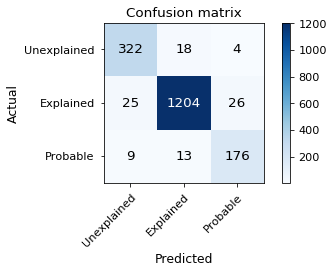

In [18]:
%matplotlib inline
sns.set_context("paper", font_scale=1.4)

y_test = test_y
y_pred = predictions

class_names = np.array(['Unexplained', 'Explained', 'Probable'])

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [19]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

y_test = data_test['researchOutcome']
y_pred = predictions
scores = precision_recall_fscore_support(y_test, y_pred, average='macro', labels=np.unique(y_pred))
acc = accuracy_score(y_test, y_pred)
print('Accuracy is: {}'.format(acc))
print('Precision is: {}'.format(scores[0]))
print('Recall is: {}'.format(scores[1]))
print('F1 score is: {}'.format(scores[2]))

Accuracy is: 0.9471341124095715
Precision is: 0.911254033162136
Recall is: 0.9280993167725309
F1 score is: 0.9194518006017468
